# Sedaro Studies Example Notebook 
Demonstrates Sedaro Studies support via the sedaro python client using a Jupyter notebook.

# Introduction  
This notebook demonstrates how to use the new Studies support added to Sedaro. 
The core of this support is the new API python client object **SimStudy**.
**SimStudy** will generate and run a series of *SimJobs* in parallel up to account capacity limits. The remaining simjobs will be placed in a queue and will be execute when resources are available. 

Each *SimJob* of a **SimStudy** will set the random seed to a different value in order to generate different output results from the simulation.
The **Overrides** feature takes this a step further by providing a means to adjust any starting value of any model of the simulation using a set of pre-defined functions. In other words, each *SimJob* of a **SimStudy** will run a baseline Scenario branch with model parameters variations in order to observe their effects on performance results.

# Setup
Running this notebook requires the following:
- A Sedaro Account             --> https://www.sedaro.com
- A Sedaro API Token           --> https://www.sedaro.com/#/account
- The Wildfire Demo Branch ID  --> login --> select/click or create workspace --> select/click Project: [DEMO] WildFire --> select/click  Repositories: [DEMO] Wildfire *Scenarios* --> copy main branch ID via clipboard icon (TODO insert screen shot)
- The Wildfire Agent branch ID --> login --> select/click or create workspace --> select/click Project: [DEMO] WildFire --> select/click  Repositories: [DEMO] Wildfire *Vehicle* --> copy main branch ID via clipboard icon (TODO insert screen shot)
- Python 3.10+ installed       --> https://www.python.org
- Jupyter notebook or lab      --> https://jupyter.org

## Pip requirements
Create/activate a python venv if desired

In [1]:
#!python -m venv /path/to/new/virtual/environment

Activate it via this table
| Platform | Shell | Command to activate virtual environment |
| :- | :- | :- |
| POSIX | bash/zsh |  source <venv>/bin/activate |
| | fish |  source <venv>/bin/activate.fish |
| | csh/tcsh |  source <venv>/bin/activate.csh |
| | PowerShell |  <venv>/bin/Activate.ps1 |
| Windows | cmd.exe | C:\> <venv>\Scripts\activate.bat |
| | PowerShell | PS C:\> <venv>\Scripts\Activate.ps1 |

Required python modules:
> replace *python* with *python3* if needed 

In [2]:
#!python -m pip install -e sedaro pytest matplotlib pandas sweetviz

or

In [3]:
#!python3.10 -m pip install  sedaro pytest matplotlib pandas sweetviz

In [4]:
#!python3.10 -m pip install sweetviz IProgress flatten_json 'fuzzywuzzy[speedup]' python-Levenshtein

Run the following cells to test if all required python modules are installed correctly

Optional module needed by the stats() function if desired 

In [5]:
import sedaro
import yaml
import json
import matplotlib.pyplot as plt
import pandas as pd
import math
import numpy as np

In [6]:
# optional
import sweetviz as sv

/usr/local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Important: Read Before Running

This notebook makes changes to agent and scenario branches indicated in the settings section. Ensure any changes to the target branches are saved prior to running this code. Sedaro recommends committing current changes and creating new branches in the target repositories to avoid loss of work.

This notebook also requires that you have previously generated an API key in the web UI. That key should be stored in a file called `secrets.json` in the same directory as this notebook with the following format:

```json
{
    "API_KEY": "<API_KEY>"
}
```

API keys grant full access to your repositories and should never be shared. If you think your API key has been compromised, you can revoke it in the user settings interface on the Sedaro website.



## Sedaro python client setup
Note: More information about the sedaro-python client can be found here: [https://github.com/sedaro/sedaro-python]


In the next cell, adjust the following variables as needed
- *Sedaro_api_host*
- *Sedaro_api_token*

In [7]:
Sedaro_api_host  = "http://localhost:80" # "api.sedaro.com"

# Set your API token value either directly or via loading a secrets file
# !! NOTE !!  Be careful not to check in your API Key into a source control repo  !! Note !!
secretPath = '/Users/sedaro/Documents/sedaro/sedaro-satellite/secrets.json'
with open(secretPath, 'r') as file:
    Sedaro_api_token = json.load(file)['API_KEY']
    
sedaroAPI = sedaro.SedaroApiClient(api_key=Sedaro_api_token, host=Sedaro_api_host)

## Load the wildfire scenario and wildfire agent branch data
Change the value of the *scenario_branch_id* and the *wildfire_agent_branch_id* in the next cell to the branch id noted above during the **Setup** section.
then run the following cell:

In [8]:
scenario_branch_id = "PKgBt4JWCmLVFBBzQBK3d8"
wildfire_scenario_branch = sedaroAPI.scenario(scenario_branch_id)

wildfire_agent_branch_id = "PKgBt3VQmHMZ8FzP9xYlsx"
wildfire_agent_branch = sedaroAPI.agent_template(wildfire_agent_branch_id)


## Wildfire Monte Carlo Analysis: Understand uncertainty of average pointing error
In this study example, we will be looking at the effects of varying Agent Model paramaters and observe its effects on the Average pointing error

The model parameters we'll vary wil be:
- Rated Moment of magnetorquers
- Rated Torque of reaction wheels
- Dry Inertia Matrix 
- along with the effects of different random seeds the sensor models use.


### Optional: Load shared workspace to skip setup and running the study
TODO

### Setup
We'll reuse the scenario_branch_id from the Wildfire Tradespace example but if it was skipped,  Find or make a branch of the wildfire scenaro and record its branch ID value.

## Research
From Wikipedia:

> A reaction wheel (RW) is used primarily by spacecraft for three-axis attitude control, and does not require rockets or external applicators of torque. They provide a high pointing accuracy,[1]: 362  and are particularly useful when the spacecraft must be rotated by very small amounts, such as keeping a telescope pointed at a star.

> A magnetorquer or magnetic torquer (also known as a torque rod) is a satellite system for attitude control, detumbling, and stabilization built from electromagnetic coils. The magnetorquer creates a magnetic dipole that interfaces with an ambient magnetic field, usually Earth's, so that the counter-forces produced provide useful torque.


Example product sheets for Reacton Wheels and a magnetorquer Rod
> https://storage.googleapis.com/blue-canyon-tech-news/1/2023/04/ReactionWheels.pdf

> https://www.newspacesystems.com/wp-content/uploads/2022/07/NewSpace-Magnetorquer-Rod_V11.2.pdf

With this information, we'll adjust the magnetorquer **ratedMagneticMoment** and the reaction wheels **ratedTorque** model parameters along with dry mass interia.

### Find model parameter path 
Looking at the Wildfire scenario, it uses the wildfire template so lets search for the parameter paths we are interested in:

In [9]:
from sedaro import AgentModelParametersOverridePaths
wildfire_agent_paths = AgentModelParametersOverridePaths(wildfire_scenario_branch, wildfire_agent_branch, agent_name='Wildfire')

First search for **ratedMagneticMoment**

In [10]:
wildfire_agent_paths.findBestMatch("ratedMagneticMoment")

'Wildfire/MT-X/ratedMagneticMoment'

Next search for **ratedTorque**

In [11]:
wildfire_agent_paths.findBestMatch("ratedTorque")

'Wildfire/RW-X/ratedTorque'

Or we could search the Wildfire Agent path list directly using
> wildfire_agent_paths.listPaths()

In [12]:
[ path for path in wildfire_agent_paths.listPaths() if "ratedTorque" in path]

['Wildfire/RW-X/ratedTorque',
 'Wildfire/RW-Y/ratedTorque',
 'Wildfire/RW-Z/ratedTorque']

In [13]:
[ path for path in wildfire_agent_paths.listPaths() if "inertia" in path]

['Wildfire/RW-X/inertia',
 'Wildfire/RW-Y/inertia',
 'Wildfire/RW-Z/inertia',
 'Wildfire/Fuel Tank/inertia',
 'Wildfire/data/inertia/0/0',
 'Wildfire/data/inertia/0/1',
 'Wildfire/data/inertia/0/2',
 'Wildfire/data/inertia/1/0',
 'Wildfire/data/inertia/1/1',
 'Wildfire/data/inertia/1/2',
 'Wildfire/data/inertia/2/0',
 'Wildfire/data/inertia/2/1',
 'Wildfire/data/inertia/2/2']

#### Wildfire Agent parameters to vary to effect average pointing error 
- Magnetorquer rated magnetic moment
  - Blocks: MT-X, MT-Y, MT-Z
    - 'Wildfire/MT-X/ratedMagneticMoment'
    - 'Wildfire/MT-Y/ratedMagneticMoment'
    - 'Wildfire/MT-Z/ratedMagneticMoment'
- Reaction wheel Rated Torque
  - Blocks: RW-X, RW-Y, RW-Z
    - 'Wildfire/RW-X/ratedTorque'
    - 'Wildfire/RW-Y/ratedTorque'
    - 'Wildfire/RW-Z/ratedTorque'
- Dry Inertia Matrix 3x3
  - Block: root
    - *Wildfire/data/inertia/#/#*


#### Determine how to vary the parameters
First lets find the starting values of the selected parameters (or you can look at the web-client)

In [14]:
wildfire_agent_paths.findValueOf('Wildfire/RW-X/ratedTorque')

0.25


> Which is the same result for **Wildfire/RW-Y/ratedTorque** and **Wildfire/RW-Z/ratedTorque** 


In [15]:

wildfire_agent_paths.findValueOf('Wildfire/MT-X/ratedMagneticMoment')

10.0

> Which is the same result for  **Wildfire/MT-Y/ratedMagneticMoment**  and  **Wildfire/MT-Z/ratedMagneticMoment**


Note: Dry inertia matrix is diagonal 


In [16]:
wildfire_agent_paths.findValueOf('Wildfire/data/inertia/0/0')


270.0

In [17]:
wildfire_agent_paths.findValueOf('Wildfire/data/inertia/1/1')

420.0

In [18]:
wildfire_agent_paths.findValueOf('Wildfire/data/inertia/2/2')

520.0

Calculate the RMS of the dry mass inertia. We will use a max of 2% of it to adjust the dry mass matrix parameters. 

In [19]:
inertia_0_0 = wildfire_agent_paths.findValueOf('Wildfire/data/inertia/0/0')
inertia_1_1 = wildfire_agent_paths.findValueOf('Wildfire/data/inertia/1/1')
inertia_2_2 = wildfire_agent_paths.findValueOf('Wildfire/data/inertia/2/2')
mean = (inertia_0_0 + inertia_1_1 + inertia_2_2)/3
# inertia_0_0_delta = inertia_0_0 - mean
# inertia_1_1_delta = inertia_1_1 - mean
# inertia_2_2_delta = inertia_2_2 - mean
mean_square = (inertia_0_0*inertia_0_0 + inertia_1_1*inertia_1_1 + inertia_2_2*inertia_2_2)/3
root_mean_square = math.sqrt(mean_square)
root_mean_square*0.02


8.324261729026384

#### Create Override dict


In [20]:
monte_carlo_overrides_dict = {
  "name": "Monte Carlo Example",
  "variables": [
    {
      "name": "inertia_root_mean_square_two_percent",
      "equals": 8.324261729026384
    },
    {
      "name": "base_ratedTorque",
      "path": "Wildfire/RW-X/ratedTorque"
    },
    {
        "name": "base_ratedMagneticMoment",
        "path": "Wildfire/MT-X/ratedMagneticMoment"
    },
    {
        "name": "base_two_percent",
        "equals": 0.02
    },
  ],
  "overrides": [ 
      {
          "path": "Wildfire/RW-X/ratedTorque",
          "fn_chain": [
            {  "fn": "*", "arg": 0.02 },
            {  "copy_value_to": "base_two_percent"},
            {  "fn": "=", "arg": "base_ratedTorque"},
            {  "fn": "normalvariate", "mu": "x", "sigma": "base_two_percent"},
          ]
      },
      {
          "path": "Wildfire/RW-Y/ratedTorque",
          "fn_chain": [
            {  "fn": "*", "arg": 0.02 },
            {  "copy_value_to": "base_two_percent"},
            {  "fn": "=", "arg": "base_ratedTorque"},
            {  "fn": "normalvariate", "mu": "x", "sigma": "base_two_percent"},
          ]
      },
      {
          "path": "Wildfire/RW-Z/ratedTorque",
          "fn_chain": [
            {  "fn": "*", "arg": 0.02 },
            {  "copy_value_to": "base_two_percent"},
            {  "fn": "=", "arg": "base_ratedTorque"},
            {  "fn": "normalvariate", "mu": "x", "sigma": "base_two_percent"},
          ]
      },
      {
          "path": "Wildfire/MT-X/ratedMagneticMoment",
          "fn_chain": [
            {  "fn": "*", "arg": 0.02 },
            {  "copy_value_to": "base_two_percent"},
            {  "fn": "=", "arg": "base_ratedMagneticMoment"},
            {  "fn": "gauss", "mu": "x", "sigma": "base_two_percent"},
          ]
      },
      {
          "path": "Wildfire/MT-Y/ratedMagneticMoment",
          "fn_chain": [
            {  "fn": "*", "arg": 0.02 },
            {  "copy_value_to": "base_two_percent"},
            {  "fn": "=", "arg": "base_ratedMagneticMoment"},
            {  "fn": "gauss", "mu": "x", "sigma": "base_two_percent"},
          ]
      },
      {
          "path": "Wildfire/MT-Z/ratedMagneticMoment",
          "fn_chain": [
            {  "fn": "*", "arg": 0.02 },
            {  "copy_value_to": "base_two_percent"},
            {  "fn": "=", "arg": "base_ratedMagneticMoment"},
            {  "fn": "gauss", "mu": "x", "sigma": "base_two_percent"},
          ]
      },
      {
          "path": "Wildfire/data/inertia/0/0",
          "fn": "normalvariate",
          "mu": "x",
          "sigma": "inertia_root_mean_square_two_percent"
      },
      {
          "path": "Wildfire/data/inertia/0/1",
          "fn": "normalvariate",
          "mu": "x",
          "sigma": "inertia_root_mean_square_two_percent"          
      },
      {
          "path": "Wildfire/data/inertia/0/2",
          "fn": "normalvariate",
          "mu": "x",
          "sigma": "inertia_root_mean_square_two_percent"          
      },      
      {
          "path": "Wildfire/data/inertia/1/0",
          "fn": "normalvariate",
          "mu": "x",
          "sigma": "inertia_root_mean_square_two_percent"          
      },      
      {
          "path": "Wildfire/data/inertia/1/1",
          "fn": "normalvariate",
          "mu": "x",
          "sigma": "inertia_root_mean_square_two_percent"
      },
      {
          "path": "Wildfire/data/inertia/1/2",
          "fn": "normalvariate",
          "mu": "x",
          "sigma": "inertia_root_mean_square_two_percent"          
      },  
      {
          "path": "Wildfire/data/inertia/2/0",
          "fn": "normalvariate",
          "mu": "x",
          "sigma": "inertia_root_mean_square_two_percent"          
      },
      {
          "path": "Wildfire/data/inertia/2/1",
          "fn": "normalvariate",
          "mu": "x",
          "sigma": "inertia_root_mean_square_two_percent"
      },          
      {
          "path": "Wildfire/data/inertia/2/2",
          "fn": "normalvariate",
          "mu": "x",
          "sigma": "inertia_root_mean_square_two_percent"
      },

  ]
}

In [21]:
#monte_carlo_overrides_block = wildfire_scenario_branch.OverrideSet.create(**monte_carlo_overrides_dict)

In [22]:
monte_carlo_overrides_block = (wildfire_scenario_branch.OverrideSet.get_last())

In [23]:
monte_carlo_overrides_block


OverrideSet(
   disabled=False
   id='PKqw2S9pDjscHCmvVShT3M'
   name='Monte Carlo Example'
   overrides=[{'agent_key': None, 'fn_chain': [{'agent_key': None, 'arg': 0.02, 'fn': '*', 'path': None}, {'agent_key': None, 'copy_value_to': 'base_two_percent', 'path': None}, {'agent_key': None, 'arg': 'base_ratedTorque', 'fn': '=', 'path': None}, {'agent_key': None, 'fn': 'normalvariate', 'mu': 'x', 'path': None, 'sigma': 'base_two_percent'}], 'path': 'Wildfire/RW-X/ratedTorque'}, {'agent_key': None, 'fn_chain': [{'agent_key': None, 'arg': 0.02, 'fn': '*', 'path': None}, {'agent_key': None, 'copy_value_to': 'base_two_percent', 'path': None}, {'agent_key': None, 'arg': 'base_ratedTorque', 'fn': '=', 'path': None}, {'agent_key': None, 'fn': 'normalvariate', 'mu': 'x', 'path': None, 'sigma': 'base_two_percent'}], 'path': 'Wildfire/RW-Y/ratedTorque'}, {'agent_key': None, 'fn_chain': [{'agent_key': None, 'arg': 0.02, 'fn': '*', 'path': None}, {'agent_key': None, 'copy_value_to': 'base_two_percen

Record the override block ID

In [24]:
monte_carlo_overrides_id = monte_carlo_overrides_block.id

#### Create and run Study

In [25]:
create_study_resource_url = f'/simulations/branches/{scenario_branch_id}/control/study/'
# new_studyjob = sedaroAPI.request.post(  create_study_resource_url,
#                                         body={
#                                             "iterations": 6,
#                                             "override_id": monte_carlo_overrides_id
#                                             })
# new_studyjob

In [26]:
[ (study['id'], study['status']) for study in sedaroAPI.request.get(  create_study_resource_url) ]

[('PKt9WsDvmPMB3wxWDJyMyQ', 'SUCCEEDED'),
 ('PKt9M25cdXw93QHrFlSLYC', 'SUCCEEDED'),
 ('PKt8XDFVn8YSmqNHSpGj2t', 'SUCCEEDED'),
 ('PKt6SK3s7dNrzbKJ6Kx7Mw', 'SUCCEEDED'),
 ('PKt3rP4NHZZWw9C65Jbp3z', 'SUCCEEDED'),
 ('PKsdmpsLdBvYd4CqNsVLrt', 'SUCCEEDED'),
 ('PKr2RfvDtkk7CyYMX9qQNT', 'ERROR'),
 ('PKr2GLVJPNqgKxvlVRTwZt', 'ERROR'),
 ('PKqygy7S9fs52wTbpY5MGW', 'ERROR'),
 ('PKqyWtYckWgffkY6pJdzMw', 'ERROR'),
 ('PKqwgJkWXtFsSdbf4tFtC2', 'SUCCEEDED'),
 ('PKqw3FrdNXpYJjW4CqBjjK', 'ERROR'),
 ('PKqV7zts8gF6CRRJxm2N5P', 'ERROR'),
 ('PKjwzmW99mRrRm4cmQGr7m', 'SUCCEEDED'),
 ('PKhCd5q3KSC46F74qgkjkt', 'ERROR'),
 ('PKhJQ4PT7hncZ3QzLBBddh', 'ERROR'),
 ('PKhGtcZxBq6nKqVshYkLx2', 'ERROR'),
 ('PKgFCsMXTkq9fbq8TnlGcT', 'SUCCEEDED'),
 ('PKgFft93CGNhdJ2m5hgMyj', 'ERROR'),
 ('PKgGXc7dzzrgbG9Wc4w2nv', 'ERROR'),
 ('PKggPzd8zHYzlxQcwC3yVc', 'ERROR'),
 ('PKggrNFqKlhbrdBG7kWCbz', 'SUCCEEDED'),
 ('PKgh6TFrWqKpN42dsnjZBV', 'SUCCEEDED'),
 ('PKghhCk7NnzRn4FlPNWbRX', 'SUCCEEDED'),
 ('PKgjSs3WrnJS7VDDwczlmQ', 'SUCCEEDED')

### Check on Study Status

In [27]:
#first_study = wildfire_scenario_branch.Study.get_first()
study_id = 'PKt9WsDvmPMB3wxWDJyMyQ' 
#study_id =  new_studyjob['id'] #
study_control_resource = f'/simulations/branches/{scenario_branch_id}/control/study/{study_id}'

In [28]:
study_status = sedaroAPI.request.get(study_control_resource)

In [29]:
study_status

{'branch': 'PKgBt4JWCmLVFBBzQBK3d8',
 'dateCreated': '2023-12-19T20:10:42.569Z',
 'dateModified': '2023-12-19T20:50:50.497Z',
 'id': 'PKt9WsDvmPMB3wxWDJyMyQ',
 'jobType': 'STUDY',
 'jobs': ['PKt9Wwft5qWyqqpCJdwlsT',
  'PKt6SV24qr8zkDSfQV7f4q',
  'PKsdn4pbkQcDB6RrzQJmGF',
  'PKqyh3357GzDlB3B9ZlJ6h',
  'PKqwgNXR2rvcFk7MMxnSs2',
  'PKqwgMPZkXBXk7Ndctwkcn'],
 'message': 'Started study successfully.',
 'predecessor': None,
 'scenarioHash': '1d3dccc5e8e0696c8785bef2507278dd7f07cc9128cfc9ba4f2a8cdfced92ef8',
 'status': 'SUCCEEDED',
 'successors': [],
 'workspace': 'PKgBsyk48JVMJcL59yvcWM'}

In [30]:
study_job_ids = study_status['jobs']
[ ( f"SimJob ID: {job['id']}", f"Status: {job['status']}", f"Progress:", job['progress']) for job_id in study_job_ids for job in [sedaroAPI.request.get(f'/simulations/branches/{scenario_branch_id}/control/{job_id}')] ]

[('SimJob ID: PKt9Wwft5qWyqqpCJdwlsT',
  'Status: SUCCEEDED',
  'Progress:',
  {'currentTime': None, 'percentComplete': 100}),
 ('SimJob ID: PKt6SV24qr8zkDSfQV7f4q',
  'Status: SUCCEEDED',
  'Progress:',
  {'currentTime': None, 'percentComplete': 100}),
 ('SimJob ID: PKsdn4pbkQcDB6RrzQJmGF',
  'Status: SUCCEEDED',
  'Progress:',
  {'currentTime': None, 'percentComplete': 100}),
 ('SimJob ID: PKqyh3357GzDlB3B9ZlJ6h',
  'Status: SUCCEEDED',
  'Progress:',
  {'currentTime': None, 'percentComplete': 100}),
 ('SimJob ID: PKqwgNXR2rvcFk7MMxnSs2',
  'Status: SUCCEEDED',
  'Progress:',
  {'currentTime': None, 'percentComplete': 100}),
 ('SimJob ID: PKqwgMPZkXBXk7Ndctwkcn',
  'Status: SUCCEEDED',
  'Progress:',
  {'currentTime': None, 'percentComplete': 100})]

### Load the results of the Study SimJobs
Load the the Study Results then load the result data from all of its  simulation set. We'll reduce the data set to 1000 points each for this example.

### Analyze Results

In [31]:
mc_study_job = wildfire_scenario_branch.study.results(study_status['id'])

In [32]:
mc_study_job.job_ids

['PKt9Wwft5qWyqqpCJdwlsT',
 'PKt6SV24qr8zkDSfQV7f4q',
 'PKsdn4pbkQcDB6RrzQJmGF',
 'PKqyh3357GzDlB3B9ZlJ6h',
 'PKqwgNXR2rvcFk7MMxnSs2',
 'PKqwgMPZkXBXk7Ndctwkcn']

In [33]:
mc_study_job.summarize() # PKt6SV24qr8zkDSfQV7f4q

---------------------------------------------------------------------------
                        Sedaro Study Result Summary                        
                       Job ID PKt9WsDvmPMB3wxWDJyMyQ                       
---------------------------------------------------------------------------
✅ Study succeeded

📋 Study contains 6 simulations

 ['PKt9Wwft5qWyqqpCJdwlsT', 'PKt6SV24qr8zkDSfQV7f4q', 'PKsdn4pbkQcDB6RrzQJmGF', 'PKqyh3357GzDlB3B9ZlJ6h', 'PKqwgNXR2rvcFk7MMxnSs2', 'PKqwgMPZkXBXk7Ndctwkcn']

❗ In-memory simulation result caching is ON
---------------------------------------------------------------------------
❓ Agent data not yet loaded. Load with .summarize_agents()
---------------------------------------------------------------------------
❓ First set desired results downsampling with:
       .set_result_limit(<# of points>) 
       .set_result_binWidth( <fraction of overall points> )   
---------------------------------------------------------------------------
❓ Qu

In [34]:
mc_study_job.set_result_limit(10000)
#j0 = mc_study_job.sim_result('PKt6SNltTYZP3qhNTR8n9x')
#j1 = mc_study_job.sim_result('PKt6SV24qr8zkDSfQV7f4q')
#j2 = mc_study_job.sim_result('PKsdn4pbkQcDB6RrzQJmGF')
#j3 = mc_study_job.sim_result('PKqyh3357GzDlB3B9ZlJ6h')
#j4 = mc_study_job.sim_result('PKqwgNXR2rvcFk7MMxnSs2')
#j5 = mc_study_job.sim_result('PKqwgMPZkXBXk7Ndctwkcn')

mc_study_job.summarize_agents()

💾 Downloading simulation result id PKt9Wwft5qWyqqpCJdwlsT.../data/PKt9XFL8qwRm2SDFtbkTYG?&limit=10000
done!
💾 Downloading simulation result id PKt6SV24qr8zkDSfQV7f4q.../data/PKt6W3Zqhd2FYzmhRH9Wv2?&limit=10000
done!
💾 Downloading simulation result id PKsdn4pbkQcDB6RrzQJmGF.../data/PKsdqVQw5DnV4VR9YycS4W?&limit=10000
done!
💾 Downloading simulation result id PKqyh3357GzDlB3B9ZlJ6h.../data/PKqyhW7wLZBr3pZnvxjRbK?&limit=10000
done!
💾 Downloading simulation result id PKqwgNXR2rvcFk7MMxnSs2.../data/PKqxftn4BgnVRJVXPT6Jc6?&limit=10000
done!
💾 Downloading simulation result id PKqwgMPZkXBXk7Ndctwkcn.../data/PKqwglVFNHs32LV9y5FfxY?&limit=10000
done!
PKt9Wwft5qWyqqpCJdwlsT:✅ Simulation succeeded after 1637.1s
PKt6SV24qr8zkDSfQV7f4q:✅ Simulation succeeded after 2698.8s
PKsdn4pbkQcDB6RrzQJmGF:✅ Simulation succeeded after 9612.6s
PKqyh3357GzDlB3B9ZlJ6h:✅ Simulation succeeded after 3201.1s
PKqwgNXR2rvcFk7MMxnSs2:✅ Simulation succeeded after 5103.1s
PKqwgMPZkXBXk7Ndctwkcn:✅ Simulation succeeded after 

In [35]:
mc_study_Wildfire_agents = mc_study_job.agents('Wildfire')

In [36]:
mc_study_Wildfire_agents.summarize()

---------------------------------------------------------------------------
                         Study Agent Result Summary                        
                                 'Wildfire'                                
                     Study ID: 'PKt9WsDvmPMB3wxWDJyMyQ'                    
---------------------------------------------------------------------------
                           Study Simulation ID's                           

 ['PKt9Wwft5qWyqqpCJdwlsT', 'PKt6SV24qr8zkDSfQV7f4q', 'PKsdn4pbkQcDB6RrzQJmGF', 'PKqyh3357GzDlB3B9ZlJ6h', 'PKqwgNXR2rvcFk7MMxnSs2', 'PKqwgMPZkXBXk7Ndctwkcn']
---------------------------------------------------------------------------
🧩 Study Simulated Modules
    • Guidance, Navigation, & Control
    • Command & Data Handling
    • Power
    • Thermal

📦 Available Blocks
    ----------------------------------------------------------
    |                  id                         name       |
    ---------------------------------------

In [37]:
mc_study_Wildfire_agents.blocks('root').summarize()

---------------------------------------------------------------------------
                   Study Simulation Block Result Summary                   
                                   'root'                                  
                     Study ID: 'PKt9WsDvmPMB3wxWDJyMyQ'                    
---------------------------------------------------------------------------
---------------------------------------------------------------------------
                           Study Simulation ID's                           

 ['PKt9Wwft5qWyqqpCJdwlsT', 'PKt6SV24qr8zkDSfQV7f4q', 'PKsdn4pbkQcDB6RrzQJmGF', 'PKqyh3357GzDlB3B9ZlJ6h', 'PKqwgNXR2rvcFk7MMxnSs2', 'PKqwgMPZkXBXk7Ndctwkcn']
---------------------------------------------------------------------------
🧩 Simulated Modules
    • Guidance, Navigation, & Control
    • Command & Data Handling
    • Power
    • Thermal

📋 Variables Available
    • attitudeError
    • attitudeSolution
    • positionSolution
    • velocitySolution
    • c

Lets take a closer look at attitudeError

In [38]:
mc_study_Wildfire_agents.blocks("root").attitudeError.summarize()

---------------------------------------------------------------------------
                   Study Simulation Series Result Summary                  
                              'attitudeError'                              
                     Study ID: 'PKt9WsDvmPMB3wxWDJyMyQ'                    
---------------------------------------------------------------------------
                           Study Simulation ID's                           

 ['PKt9Wwft5qWyqqpCJdwlsT', 'PKt6SV24qr8zkDSfQV7f4q', 'PKsdn4pbkQcDB6RrzQJmGF', 'PKqyh3357GzDlB3B9ZlJ6h', 'PKqwgNXR2rvcFk7MMxnSs2', 'PKqwgMPZkXBXk7Ndctwkcn']
---------------------------------------------------------------------------
                    Study Simulation Series Data Summary                   
                              'attitudeError'                              
---------------------------------------------------------------------------
📈 sim_id:PKt9Wwft5qWyqqpCJdwlsT 5343 points covering 494.5 minutes with ~5.6s ste

In [39]:
mc_study_Wildfire_agents.blocks("root").attitudeError.study_stats()

count      mean       std       min   
PKt9Wwft5qWyqqpCJdwlsT attitudeError.0  5341.0 -0.048010  0.688617 -3.136224  \
                       attitudeError.1  5341.0 -0.045837  0.321221 -1.487279   
                       attitudeError.2  5341.0  0.008514  0.554276 -3.136522   
PKt6SV24qr8zkDSfQV7f4q attitudeError.0  5378.0 -0.051690  0.693556 -3.140959   
                       attitudeError.1  5378.0 -0.046404  0.325204 -1.533370   
                       attitudeError.2  5378.0  0.012862  0.562388 -3.127983   
PKsdn4pbkQcDB6RrzQJmGF attitudeError.0  5354.0 -0.054234  0.689193 -3.138487   
                       attitudeError.1  5354.0 -0.046050  0.320730 -1.527403   
                       attitudeError.2  5354.0  0.010064  0.560333 -3.113848   
PKqyh3357GzDlB3B9ZlJ6h attitudeError.0  5363.0 -0.053177  0.689592 -3.120793   
                       attitudeError.1  5363.0 -0.046372  0.323522 -1.534804   
                       attitudeError.2  5363.0  0.013398  0.561797 -3.135191   
PKqwgNXR2rvcFk7MMxnSs2 attitudeError.0  5347.0 -0.051460  0.678739 -3.126226   
                       attitudeError.1  5347.0 -0.045197  0.319308 -1.427092   
                       attitudeError.2  5347.0  0.016645  0.560184 -3.141032   
PKqwgMPZkXBXk7Ndctwkcn attitudeError.0  5364.0 -0.053130  0.682964 -3.126952   
                       attitudeError.1  5364.0 -0.045052  0.320751 -1.422131   
                       attitudeError.2  5364.0  0.016401  0.561646 -3.139593   

                                             25%       50%       75%       max  
PKt9Wwft5qWyqqpCJdwlsT attitudeError.0 -0.025761 -0.003575  0.000887  3.138236  
                       attitudeError.1 -0.046930 -0.009812  0.004903  1.482167  
                       attitudeError.2 -0.019154 -0.015626  0.009160  3.057467  
PKt6SV24qr8zkDSfQV7f4q attitudeError.0 -0.026460 -0.003594  0.000664  3.138345  
                       attitudeError.1 -0.047976 -0.009891  0.005369  1.453901  
                       attitudeError.2 -0.018999 -0.015974  0.009678  3.118083  
PKsdn4pbkQcDB6RrzQJmGF attitudeError.0 -0.026509 -0.003584  0.000490  3.135838  
                       attitudeError.1 -0.044339 -0.009918  0.003906  1.453918  
                       attitudeError.2 -0.019101 -0.016104  0.008561  3.100272  
PKqyh3357GzDlB3B9ZlJ6h attitudeError.0 -0.026316 -0.003705  0.000680  3.139529  
                       attitudeError.1 -0.048097 -0.009585  0.005309  1.506415  
                       attitudeError.2 -0.019065 -0.015387  0.009777  3.065103  
PKqwgNXR2rvcFk7MMxnSs2 attitudeError.0 -0.026204 -0.003364  0.000597  3.136833  
                       attitudeError.1 -0.042299 -0.009564  0.004900  1.472735  
                       attitudeError.2 -0.019038 -0.015864  0.009121  3.107875  
PKqwgMPZkXBXk7Ndctwkcn attitudeError.0 -0.026435 -0.003568  0.000519  3.135033  
                       attitudeError.1 -0.039564 -0.009568  0.006705  1.470157  
                       attitudeError.2 -0.019146 -0.015936  0.010389  3.062291

Due to the data type of attitudeError being a list, a list of roll-pitch-yaw radians in this case, we'll use the study sub_plots feature 

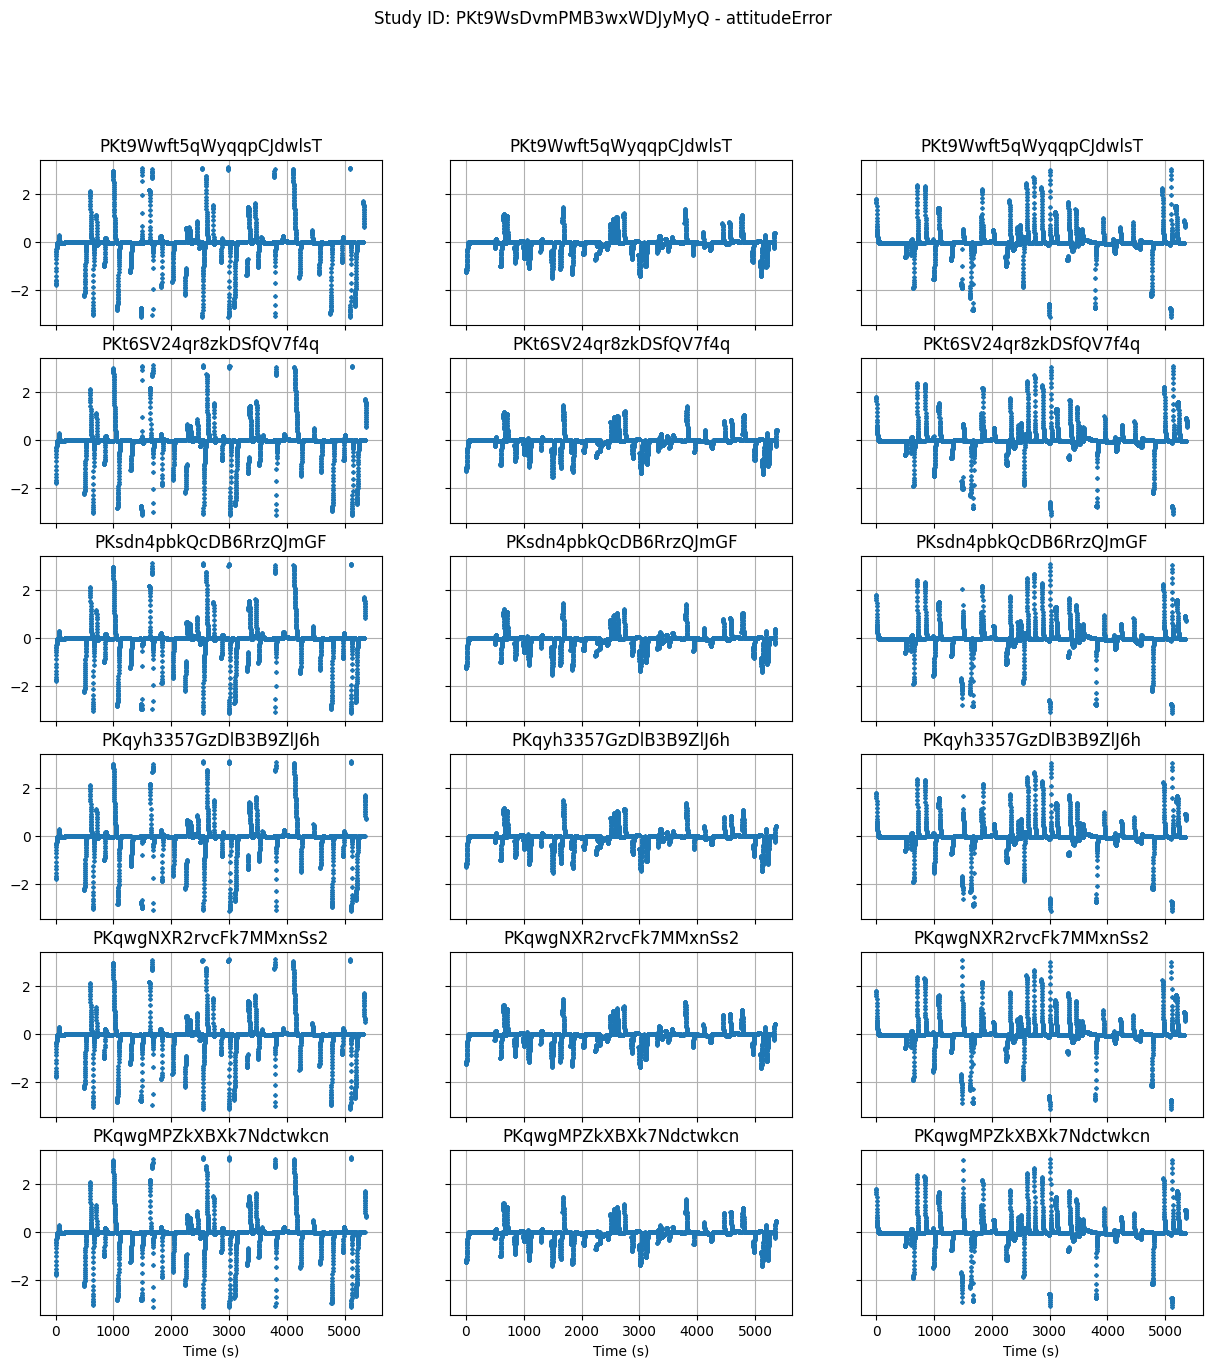

In [41]:
mc_study_Wildfire_agents.blocks("root").attitudeError.study_subplots(size=15,cols=3)

array([[<Axes: title={'center': "('PKt9Wwft5qWyqqpCJdwlsT', 'attitudeError.0')"}>,
        <Axes: title={'center': "('PKt9Wwft5qWyqqpCJdwlsT', 'attitudeError.1')"}>,
        <Axes: title={'center': "('PKt9Wwft5qWyqqpCJdwlsT', 'attitudeError.2')"}>,
        <Axes: title={'center': "('PKt6SV24qr8zkDSfQV7f4q', 'attitudeError.0')"}>],
       [<Axes: title={'center': "('PKt6SV24qr8zkDSfQV7f4q', 'attitudeError.1')"}>,
        <Axes: title={'center': "('PKt6SV24qr8zkDSfQV7f4q', 'attitudeError.2')"}>,
        <Axes: title={'center': "('PKsdn4pbkQcDB6RrzQJmGF', 'attitudeError.0')"}>,
        <Axes: title={'center': "('PKsdn4pbkQcDB6RrzQJmGF', 'attitudeError.1')"}>],
       [<Axes: title={'center': "('PKsdn4pbkQcDB6RrzQJmGF', 'attitudeError.2')"}>,
        <Axes: title={'center': "('PKqyh3357GzDlB3B9ZlJ6h', 'attitudeError.0')"}>,
        <Axes: title={'center': "('PKqyh3357GzDlB3B9ZlJ6h', 'attitudeError.1')"}>,
        <Axes: title={'center': "('PKqyh3357GzDlB3B9ZlJ6h', 'attitudeError.2')"}>],
 

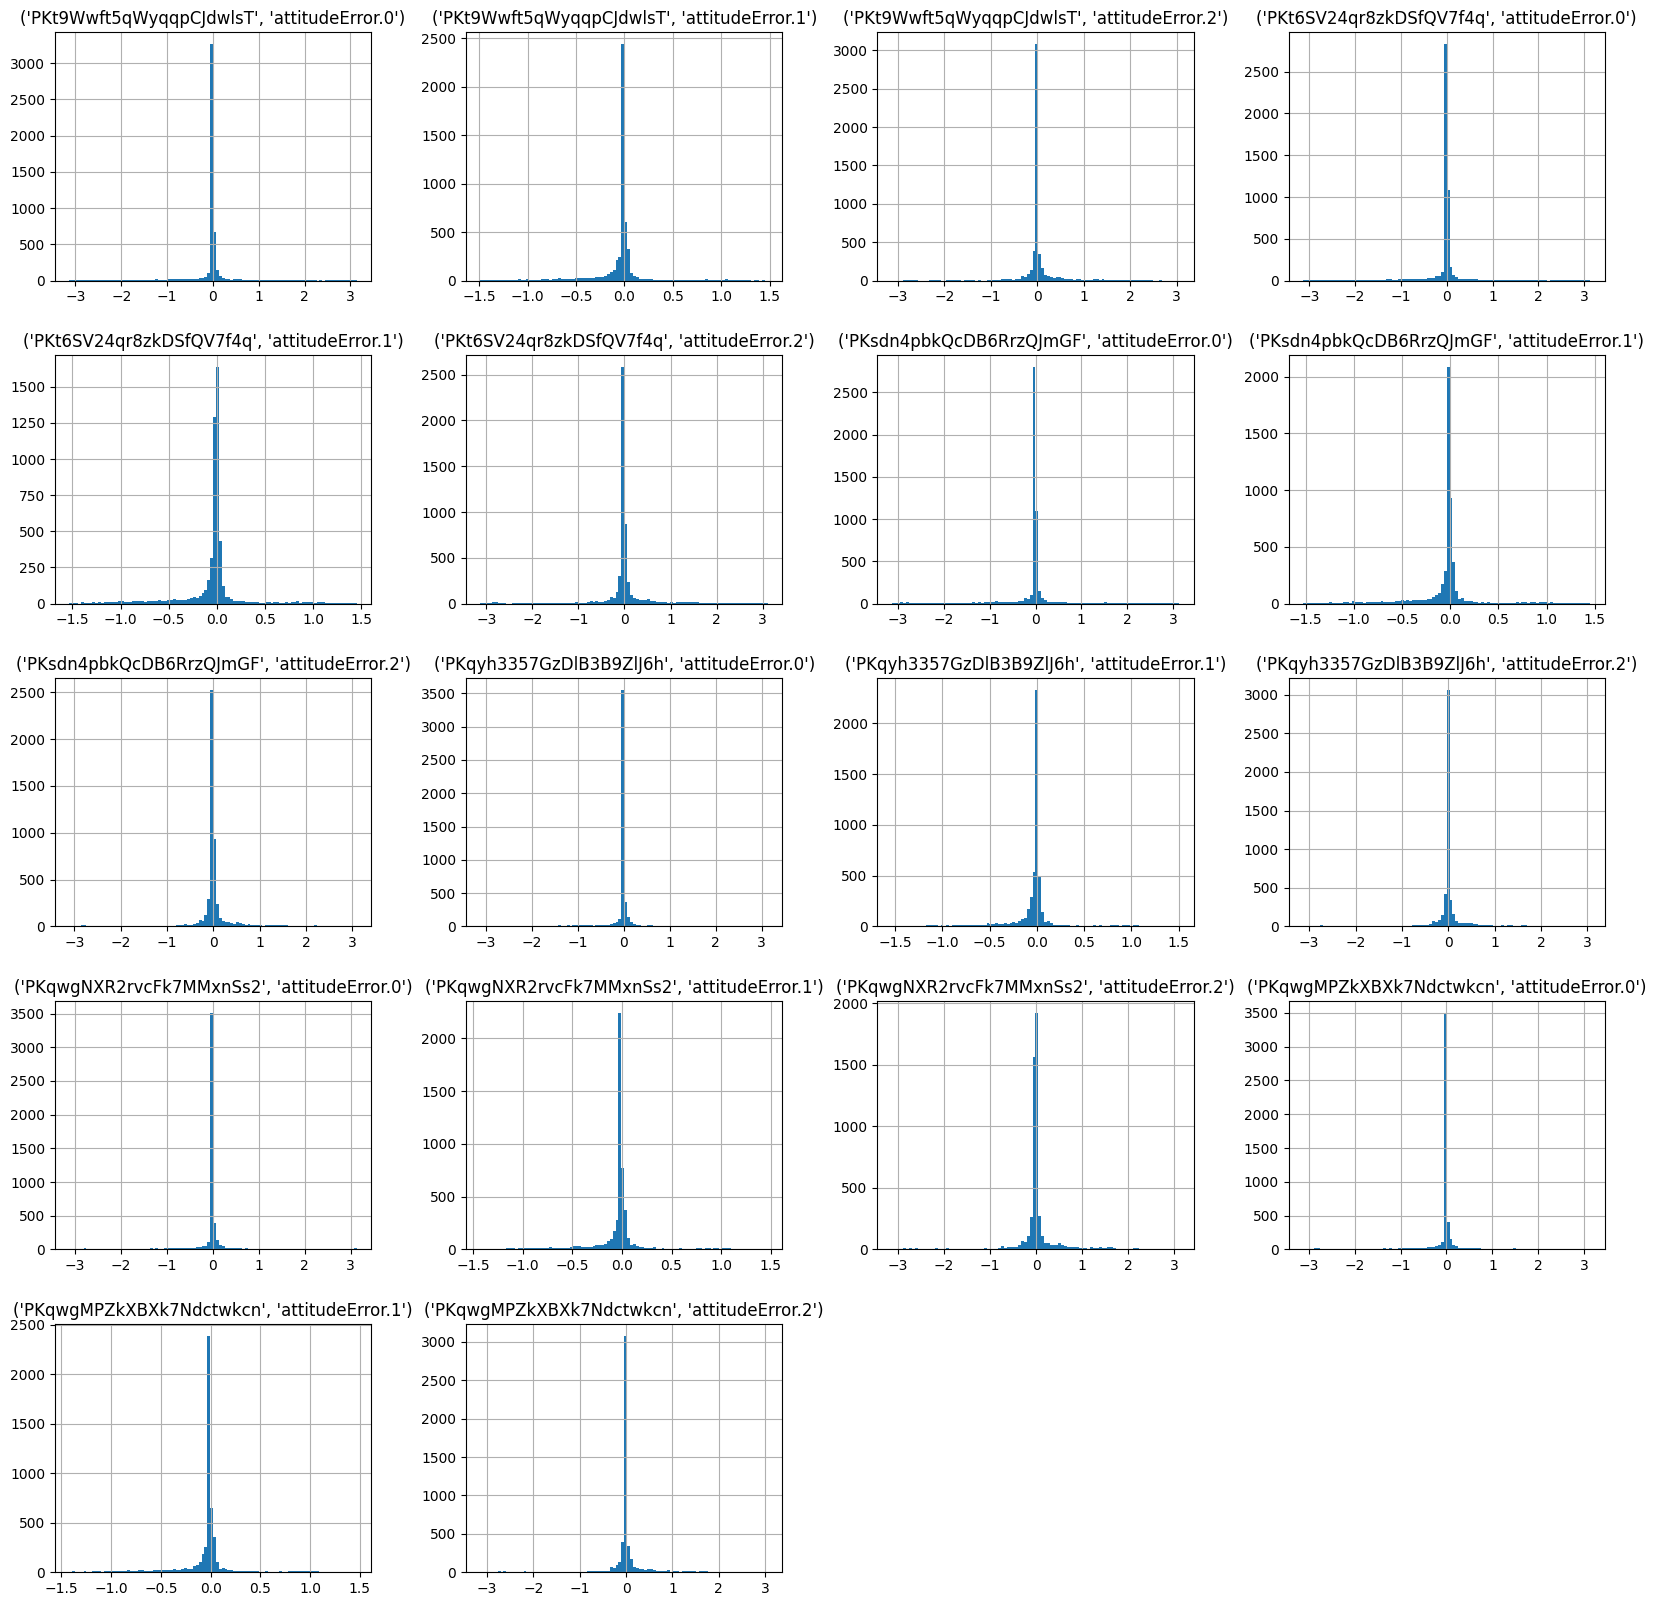

In [42]:
mc_study_Wildfire_agents.blocks("root").attitudeError.study_histogram(size=20, bins=100)

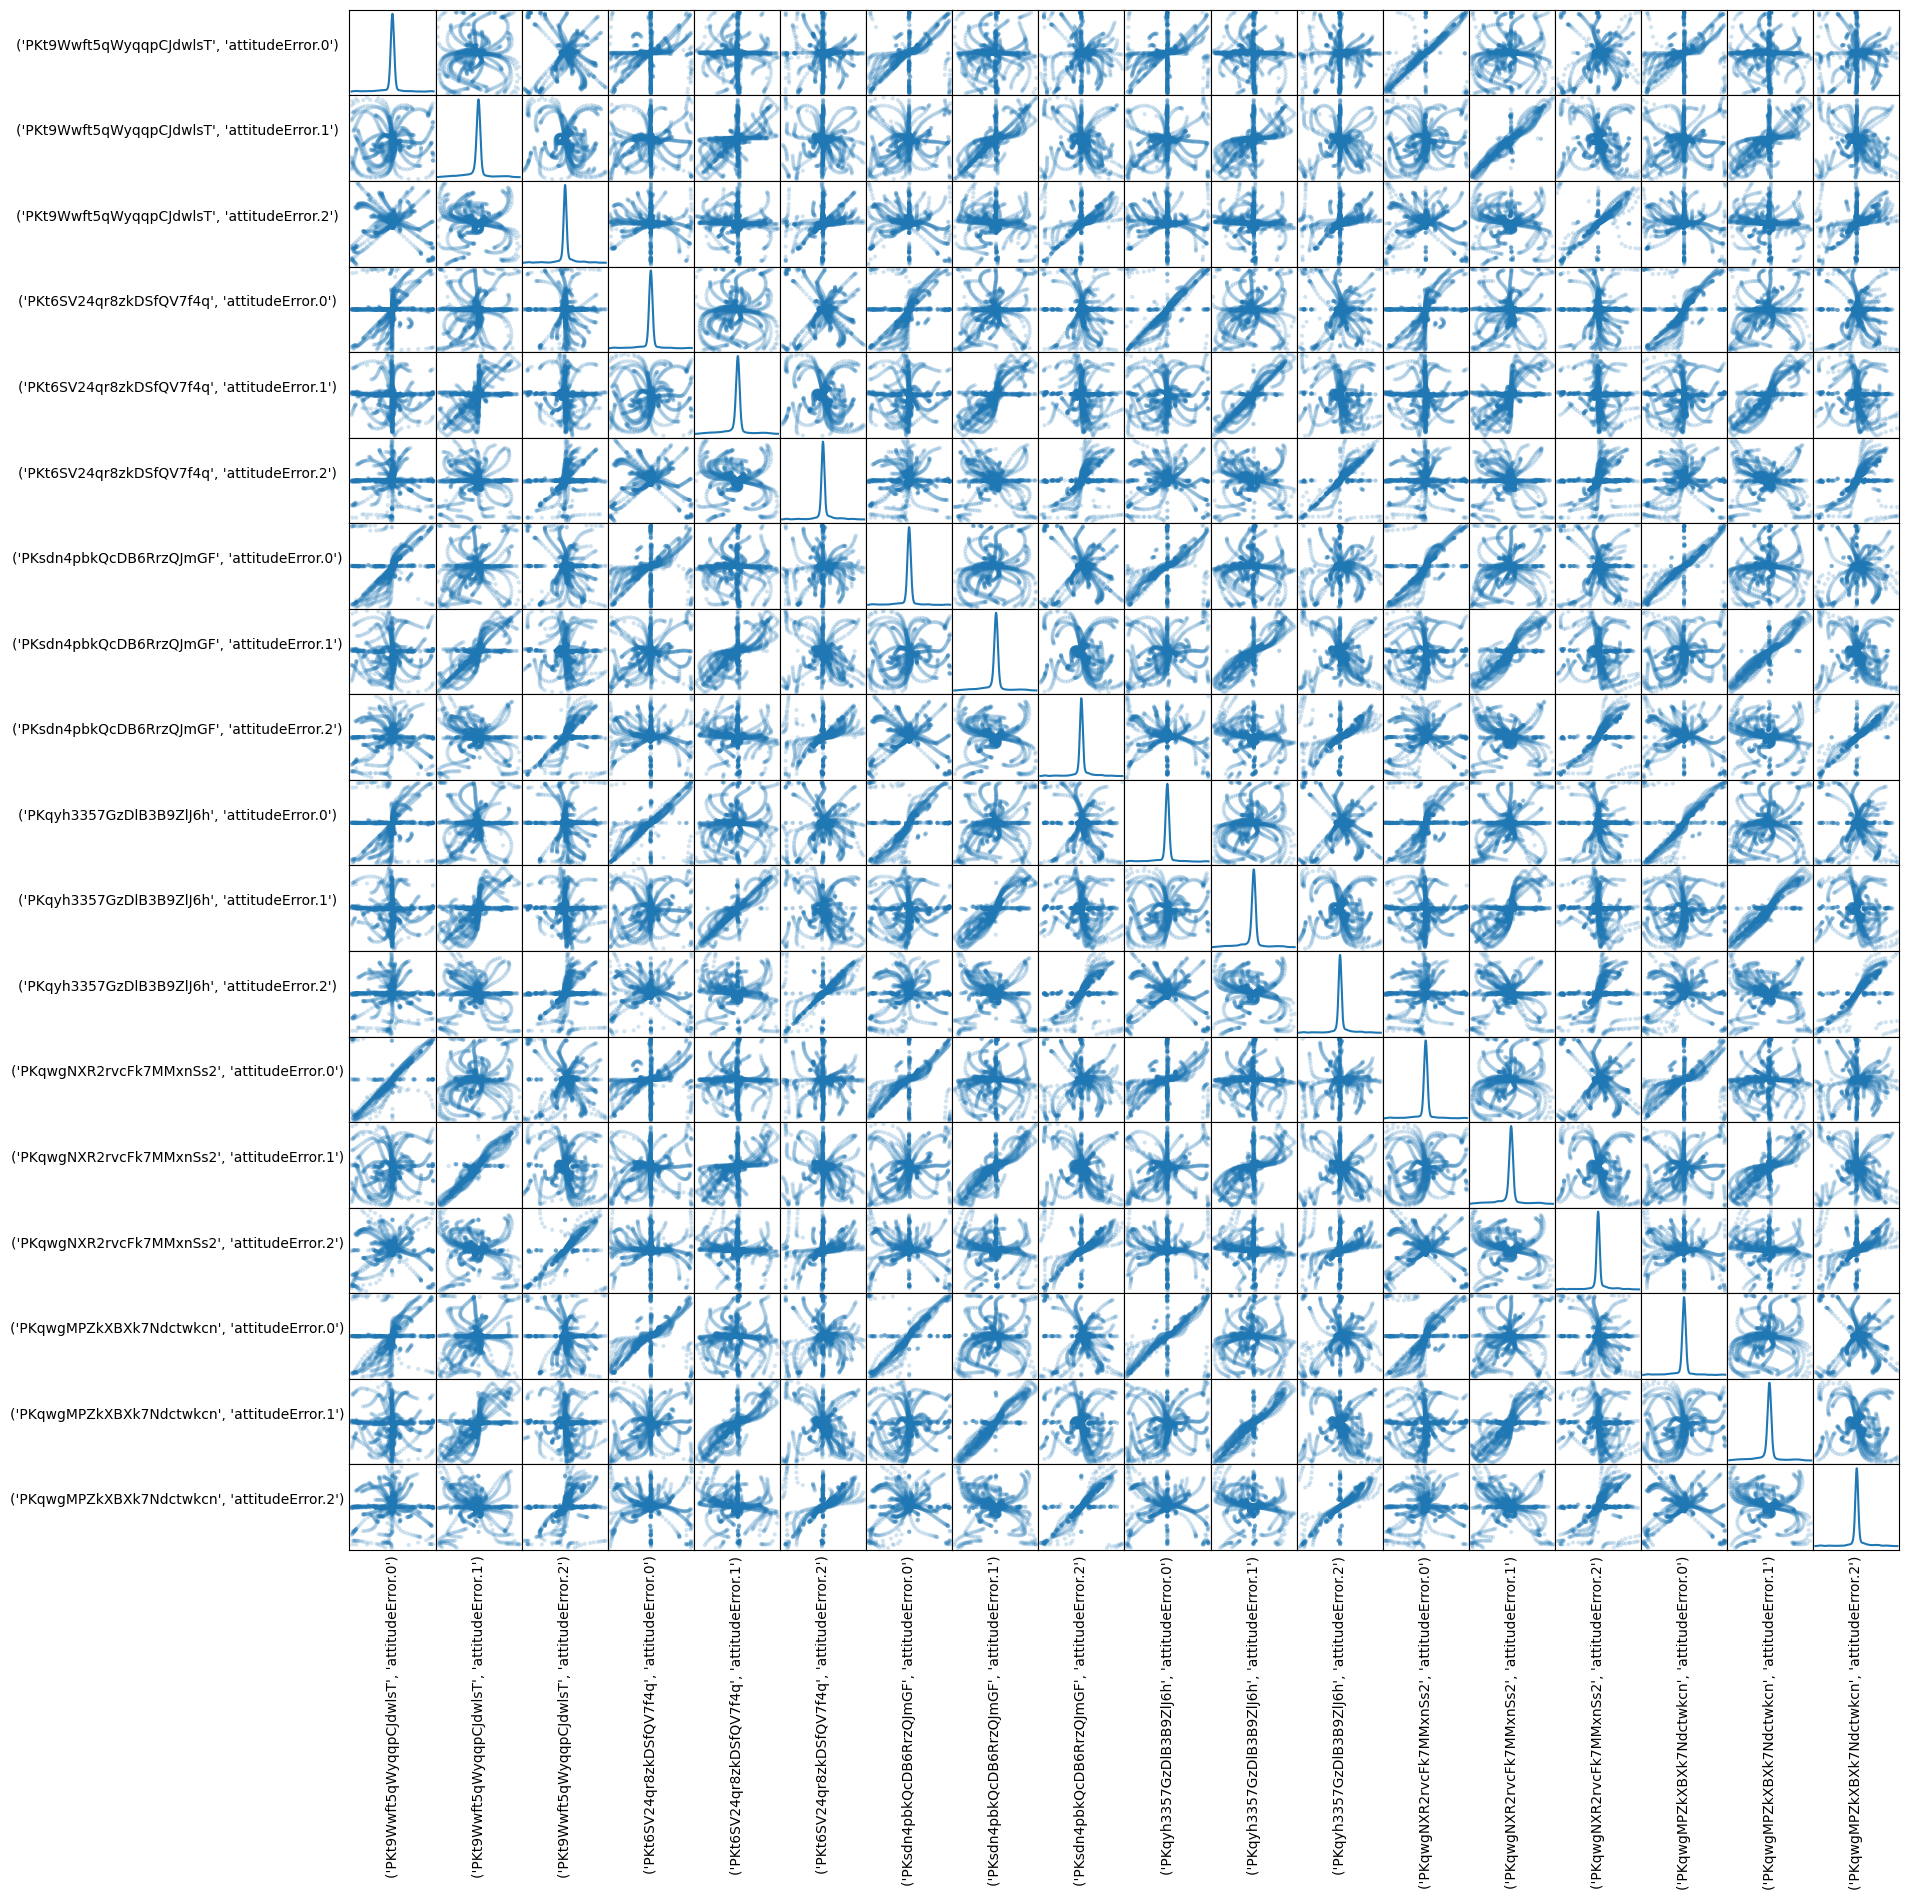

In [44]:
mc_study_Wildfire_agents.blocks("root").attitudeError.study_scatter_matrix(size=20)

Lets look at th eangle between the attittude body quaternion and the commandAttitude

In [45]:
import utils
import itertools
simID_to_body_eci_quaternion = { sim_id: np.array(series.values) for (sim_id,series) in mc_study_Wildfire_agents.blocks("root").attitude.body_eci.items() }

In [46]:
mc_study_Wildfire_agents.blocks("root").commandedAttitude.summarize()

---------------------------------------------------------------------------
                   Study Simulation Series Result Summary                  
                            'commandedAttitude'                            
                     Study ID: 'PKt9WsDvmPMB3wxWDJyMyQ'                    
---------------------------------------------------------------------------
                           Study Simulation ID's                           

 ['PKt9Wwft5qWyqqpCJdwlsT', 'PKt6SV24qr8zkDSfQV7f4q', 'PKsdn4pbkQcDB6RrzQJmGF', 'PKqyh3357GzDlB3B9ZlJ6h', 'PKqwgNXR2rvcFk7MMxnSs2', 'PKqwgMPZkXBXk7Ndctwkcn']
---------------------------------------------------------------------------
                    Study Simulation Series Data Summary                   
                            'commandedAttitude'                            
---------------------------------------------------------------------------
📈 sim_id:PKt9Wwft5qWyqqpCJdwlsT 5343 points covering 494.5 minutes with ~5.6s ste

In [47]:
mc_study_Wildfire_agents.blocks("root").commandedAttitude.study_stats()

count      mean       std   
PKt9Wwft5qWyqqpCJdwlsT commandedAttitude.0  5342.0  0.023798  0.195198  \
                       commandedAttitude.1  5342.0 -0.171034  0.559909   
                       commandedAttitude.2  5342.0 -0.262752  0.536987   
                       commandedAttitude.3  5342.0  0.399790  0.318582   
PKt6SV24qr8zkDSfQV7f4q commandedAttitude.0  5379.0  0.023667  0.195011   
                       commandedAttitude.1  5379.0 -0.172362  0.560371   
                       commandedAttitude.2  5379.0 -0.260896  0.537875   
                       commandedAttitude.3  5379.0  0.398777  0.318474   
PKsdn4pbkQcDB6RrzQJmGF commandedAttitude.0  5355.0  0.024192  0.195314   
                       commandedAttitude.1  5355.0 -0.171411  0.560028   
                       commandedAttitude.2  5355.0 -0.263433  0.536480   
                       commandedAttitude.3  5355.0  0.399481  0.318746   
PKqyh3357GzDlB3B9ZlJ6h commandedAttitude.0  5364.0  0.023792  0.194608   
                       commandedAttitude.1  5364.0 -0.172488  0.559588   
                       commandedAttitude.2  5364.0 -0.262344  0.537933   
                       commandedAttitude.3  5364.0  0.398944  0.318521   
PKqwgNXR2rvcFk7MMxnSs2 commandedAttitude.0  5348.0  0.024179  0.194835   
                       commandedAttitude.1  5348.0 -0.171330  0.559952   
                       commandedAttitude.2  5348.0 -0.262755  0.537862   
                       commandedAttitude.3  5348.0  0.398761  0.318352   
PKqwgMPZkXBXk7Ndctwkcn commandedAttitude.0  5365.0  0.023846  0.194386   
                       commandedAttitude.1  5365.0 -0.172513  0.559839   
                       commandedAttitude.2  5365.0 -0.261846  0.538386   
                       commandedAttitude.3  5365.0  0.398428  0.318490   

                                                 min           25%   
PKt9Wwft5qWyqqpCJdwlsT commandedAttitude.0 -0.735423 -3.715068e-17  \
                       commandedAttitude.1 -0.972628 -5.867194e-01   
                       commandedAttitude.2 -0.972573 -8.110550e-01   
                       commandedAttitude.3  0.000028  1.133883e-01   
PKt6SV24qr8zkDSfQV7f4q commandedAttitude.0 -0.735382 -3.745669e-17   
                       commandedAttitude.1 -0.972630 -5.894080e-01   
                       commandedAttitude.2 -0.972574 -8.098356e-01   
                       commandedAttitude.3  0.000017  1.126323e-01   
PKsdn4pbkQcDB6RrzQJmGF commandedAttitude.0 -0.735407 -3.718544e-17   
                       commandedAttitude.1 -0.972630 -5.878327e-01   
                       commandedAttitude.2 -0.972576 -8.114978e-01   
                       commandedAttitude.3  0.000296  1.130976e-01   
PKqyh3357GzDlB3B9ZlJ6h commandedAttitude.0 -0.735486 -3.733412e-17   
                       commandedAttitude.1 -0.972630 -5.876366e-01   
                       commandedAttitude.2 -0.972576 -8.119123e-01   
                       commandedAttitude.3  0.000095  1.125936e-01   
PKqwgNXR2rvcFk7MMxnSs2 commandedAttitude.0 -0.735424 -3.713191e-17   
                       commandedAttitude.1 -0.972629 -5.857398e-01   
                       commandedAttitude.2 -0.972575 -8.114482e-01   
                       commandedAttitude.3  0.000385  1.125733e-01   
PKqwgMPZkXBXk7Ndctwkcn commandedAttitude.0 -0.735412 -3.760205e-17   
                       commandedAttitude.1 -0.972630 -5.894330e-01   
                       commandedAttitude.2 -0.972576 -8.117731e-01   
                       commandedAttitude.3  0.000129  1.125381e-01   

                                                     50%       75%       max  
PKt9Wwft5qWyqqpCJdwlsT commandedAttitude.0  6.262823e-18  0.109653  0.693765  
                       commandedAttitude.1 -2.147607e-01  0.290019  0.957444  
                       commandedAttitude.2 -3.200040e-01  0.166375  0.748358  
                       commandedAttitude.3  2.765189e-01  0.653851  0.999648  
PKt6SV24qr8zkDSfQV7f4q commandedAttitude.0  5.81

In [48]:
simID_to_commandedAttitude_quaternion = { sim_id: np.array( [value for value in  series.values if value is not None]) for (sim_id,series) in mc_study_Wildfire_agents.blocks("root").commandedAttitude.values.items() }

In [51]:
angle_between_them = { sim_id: [ utils.angleBetweenQuaternion(body,commanded) for (body,commanded) in zip(simID_to_body_eci_quaternion[sim_id], simID_to_commandedAttitude_quaternion[sim_id]) ]
                      for sim_id in simID_to_body_eci_quaternion.keys()
                       }

Due to each sim having a different number of results entries, use the following trick to add NaN to make them all the same size.
We are not comparing each result index to other and the Nan are filtered for the stat calculations

In [63]:
angle_between_them_df = pd.DataFrame.from_dict(angle_between_them, orient='index').T

In [64]:
angle_between_them_df.describe().T

count      mean       std       min       25%   
PKt9Wwft5qWyqqpCJdwlsT  5342.0  0.398718  0.674676  0.003938  0.036697  \
PKt6SV24qr8zkDSfQV7f4q  5379.0  0.406137  0.678232  0.004071  0.036935   
PKsdn4pbkQcDB6RrzQJmGF  5355.0  0.402429  0.676941  0.003724  0.037162   
PKqyh3357GzDlB3B9ZlJ6h  5364.0  0.402609  0.676128  0.003529  0.036416   
PKqwgNXR2rvcFk7MMxnSs2  5348.0  0.397947  0.671191  0.002634  0.036807   
PKqwgMPZkXBXk7Ndctwkcn  5365.0  0.401193  0.673957  0.004681  0.036904   

                             50%       75%       max  
PKt9Wwft5qWyqqpCJdwlsT  0.066925  0.332714  3.132132  
PKt6SV24qr8zkDSfQV7f4q  0.069563  0.355351  3.128933  
PKsdn4pbkQcDB6RrzQJmGF  0.067971  0.344561  3.130450  
PKqyh3357GzDlB3B9ZlJ6h  0.068231  0.347444  3.129288  
PKqwgNXR2rvcFk7MMxnSs2  0.067154  0.331800  3.128420  
PKqwgMPZkXBXk7Ndctwkcn  0.068140  0.338812  3.129054

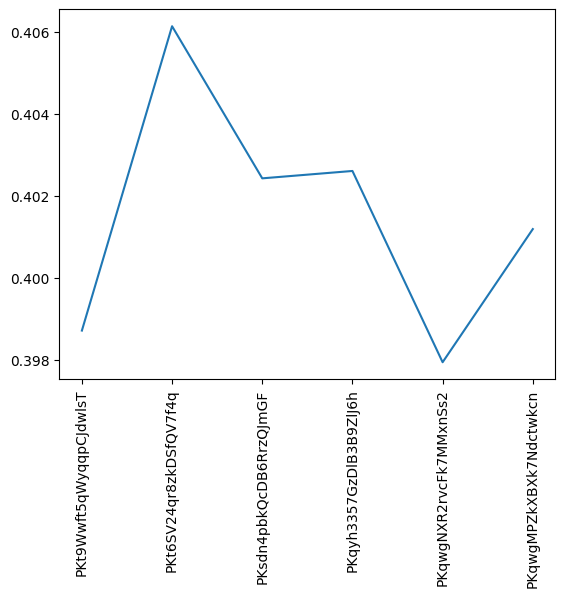

In [66]:
angle_between_them_df.describe().T['mean'].plot()
plt.xticks(rotation=90)
plt.show()